In [1]:
import pandas as pd
import numpy as np

import matplotlib 
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.stats import relfreq

import networkx as nx

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')

In [3]:
df.drop(columns=['artist_base', 'song'], inplace=True)
df.rename(columns={'artist_clean': 'artist_base', 'song_clean': 'song'}, inplace=True)

# Artist collaboration over time

Text(1962, 1.5, 'Billboard Year-End\nHot 100 1960-2022')

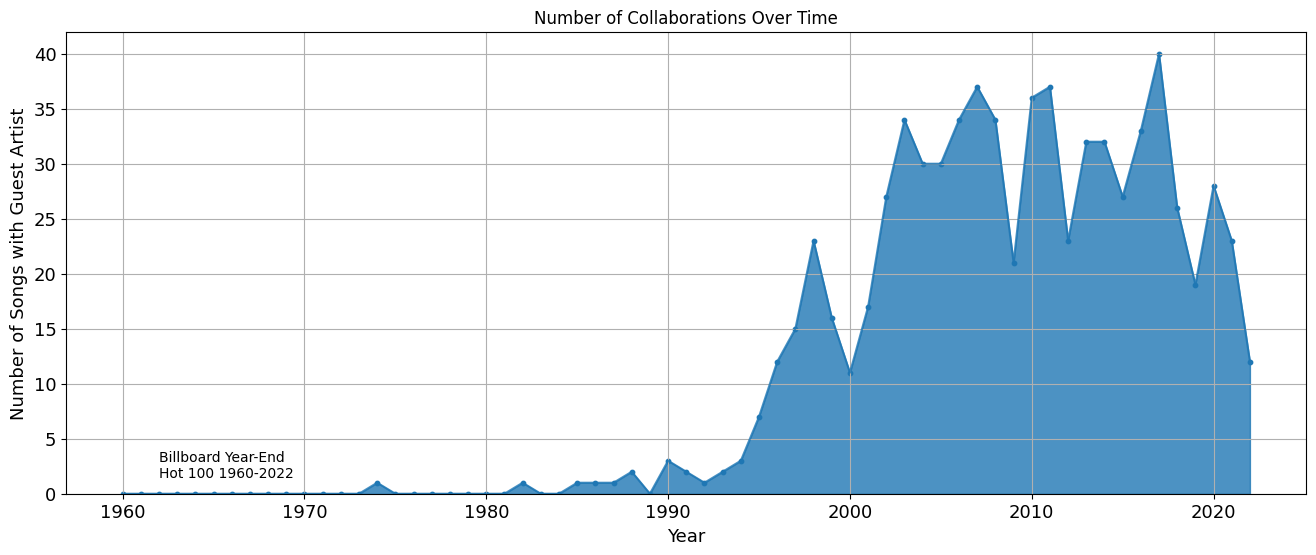

In [5]:
# collaboration counted if artist name contains "featuring"
df_collab = df[df['artist_all'].str.contains('featuring')]
df_collab = df_collab.groupby(['year'])['artist_base']\
                     .count().reindex(range(1960, 2023))
df_collab = df_collab.fillna(0)

# generate line plot and augment with points
ax = df_collab.plot.area(figsize=(16,6), grid=True, alpha=0.8)
ax.scatter(df_collab.index, df_collab, s=10)
ax.set_ylabel('Number of Songs with Guest Artist',fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set(title='Number of Collaborations Over Time')
ax.annotate('Billboard Year-End\nHot 100 1960-2022',
            xy=(1962,1.5))

/tmp/ipykernel_9016/132208057.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


Text(0.5, 1.04, 'Number of Collaborations per Artist')

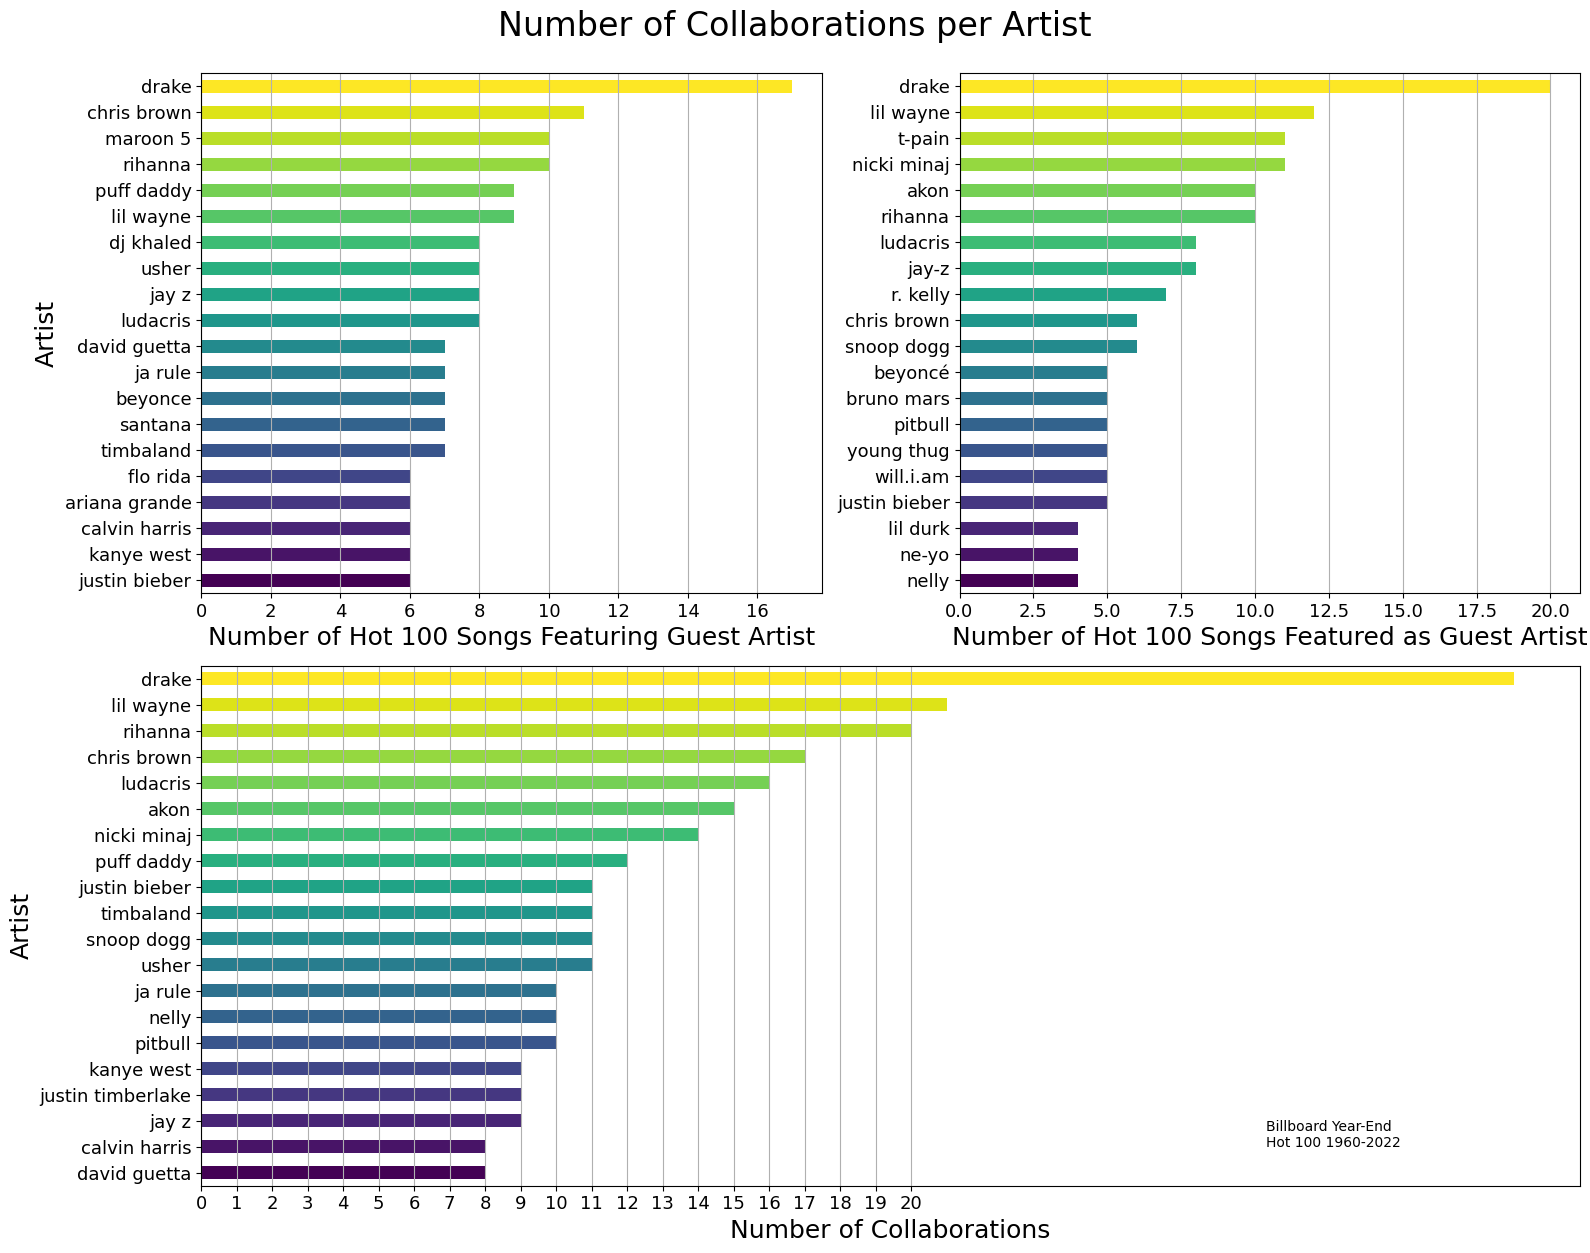

In [6]:
cmap = plt.cm.get_cmap('viridis')
colors = [cmap(x) for x in np.linspace(0, 1, 20)]

# generate subplots
axes = list()
plt.figure(figsize=(16,12))
grid_positions = [221, 222, 212]
for position in grid_positions:
    axes.append(plt.subplot(position))

# calculate "featuring" vs "featured" stats for each artist
featuring = df.groupby('artist_base')['artist_featured'].count()
featured = df['artist_featured'].value_counts()

# generate upper two plots
featuring.sort_values().tail(20).plot.barh(ax=axes[0], color=colors)
featured.sort_values().tail(20).plot.barh(ax=axes[1], color=colors)
axes[0].set_xlabel('Number of Hot 100 Songs Featuring Guest Artist', fontsize=18)
axes[0].set_ylabel('Artist', fontsize=18)

axes[1].set_xlabel('Number of Hot 100 Songs Featured as Guest Artist', fontsize=18)

# indices must be reset for merging by artist
featuring = featuring.reset_index()
featured = featured.reset_index()
merged = pd.merge(featuring, featured, how='inner', left_on='artist_base',
                  right_on='index')
merged = merged.drop('index', axis=1)

# calculate number of collborations from "featuring" and "featured" stats
merged.columns = ['artist', 'n_featuring', 'n_featured']
merged['n_collab'] = merged['n_featuring'] + merged['n_featured']
merged = merged.set_index('artist') # for yticklabels when plotting

# generate lower plot
axes[2] = merged['n_collab'].sort_values().tail(20).plot.barh(color=colors)
axes[2].set_xlabel('Number of Collaborations', fontsize=18)
axes[2].set_ylabel('Artist', fontsize=18)
axes[2].set_xticks(range(0,21,1));
axes[2].annotate('Billboard Year-End\nHot 100 1960-2022',
    xy=(30,1))

# final touches
for ax in axes:
    ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle('Number of Collaborations per Artist', fontsize=24, y=1.04)

# Collaboration connection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


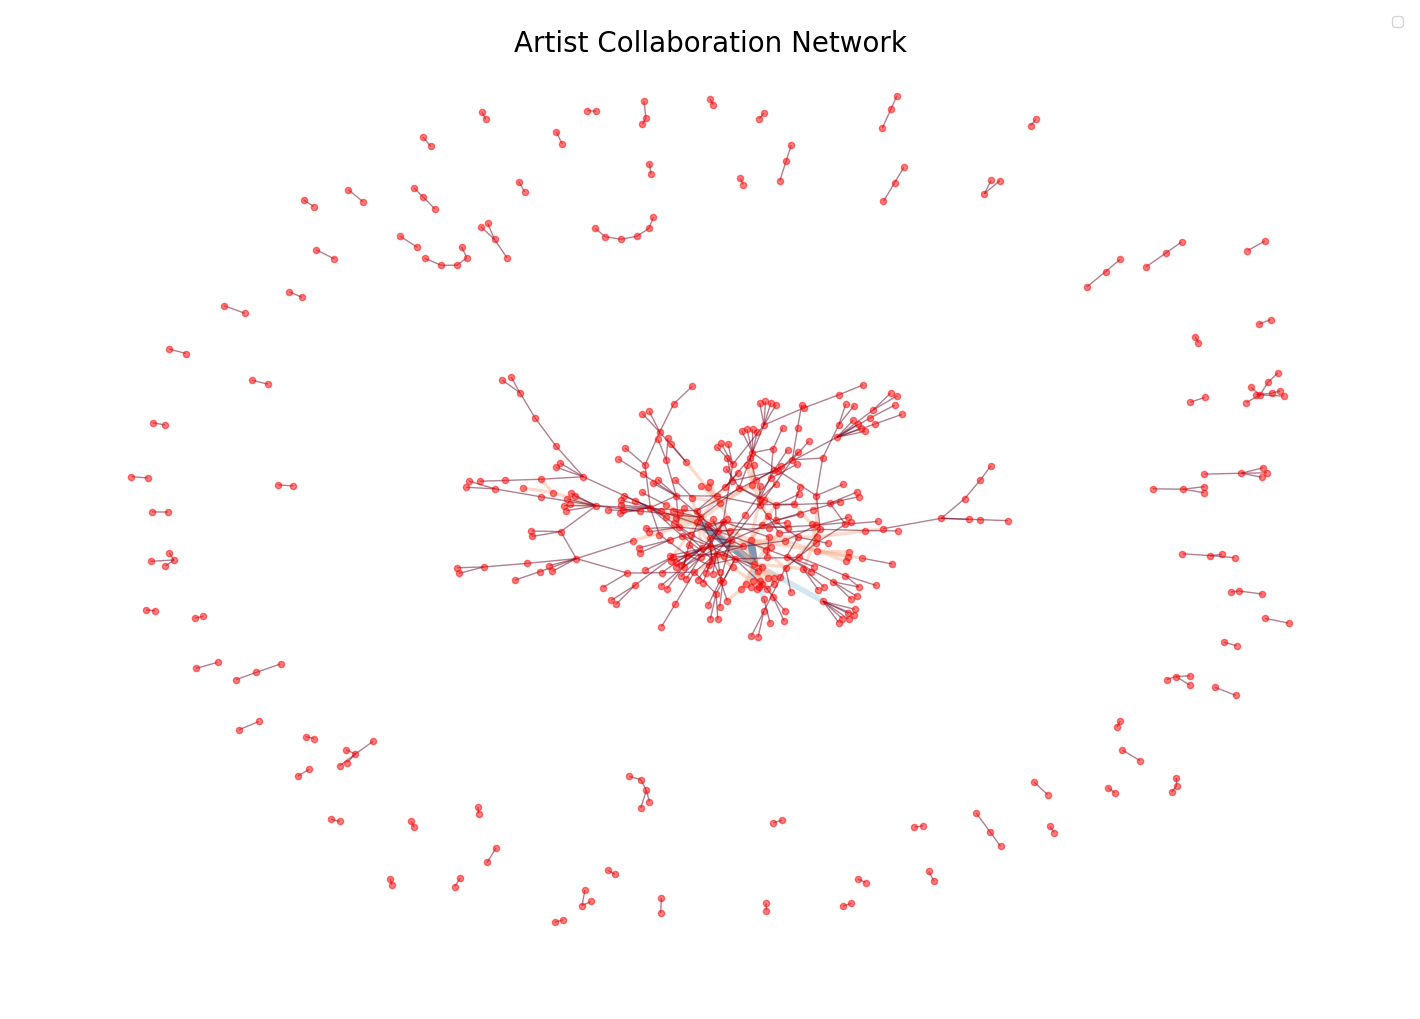

In [7]:
# exclude single-hit artist to simply network visualization
vc = df.artist_base.value_counts()
exclude = vc[vc == 1].index

# visualize collaborations as undirected edges weighted by frequency
edges = df[df.artist_featured.notnull()][['artist_base', 'artist_featured']]
u_edges = list()
for index, row in edges.iterrows():
    artist1 = row['artist_base'].strip()
    artist2 = row['artist_featured'].strip()
    if artist1 in exclude or artist2 in exclude:
        continue
    # to use groupby to obtain weights, must first normalize all artist pairs
    # normalize artist pair by rearranging alphabetically
    new_row = sorted([artist1, artist2])
    u_edges.append(new_row)

# use dummy column of ones and multi-column groupby to obtain edge frequencies
u_edges_df = pd.DataFrame(u_edges)
u_edges_df['one'] = 1
u_edges_df = u_edges_df.groupby([0, 1])['one']\
                       .count().sort_values(ascending=False).reset_index()
u_edges_df.columns = ['artist1', 'artist2', 'degree']

# generate graph. edge width and color is function of frequency (degrees)
degrees = u_edges_df['degree']
u_edges = u_edges_df[['artist1', 'artist2']]
u_edges = u_edges.values.tolist()
graph = nx.Graph(directed=True)
graph.add_edges_from(u_edges)
plt.figure(figsize=(14,10))
nx.draw_spring(graph, node_size=20, edge_color=degrees, edge_cmap=plt.cm.RdBu,
               width=degrees**1.25, alpha=0.5, font_size=5, node_color='r')
plt.suptitle('Artist Collaboration Network', fontsize=20)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


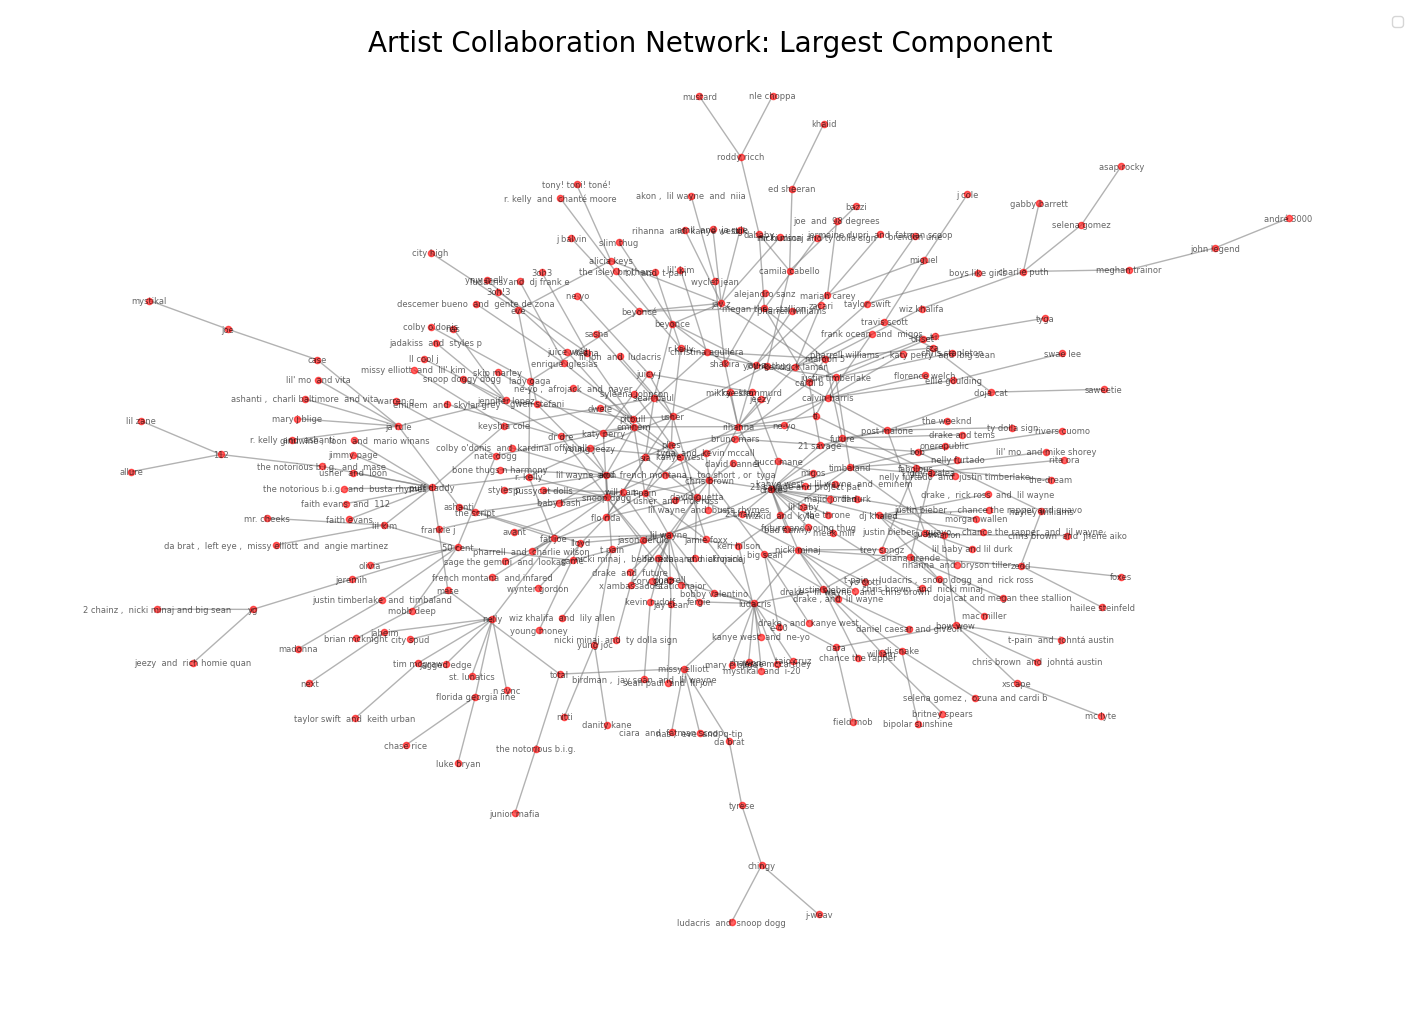

In [8]:
# plot largest component of graph
component = max((graph.subgraph(c) for c in nx.connected_components(graph)), key=len)
plt.figure(figsize=(14,10))
nx.draw_kamada_kawai(component, node_size=20, with_labels=True, font_size=6,
                     alpha=0.6, edge_color='gray', node_color='r')
plt.suptitle('Artist Collaboration Network: Largest Component', fontsize=20)
plt.legend()